In [11]:
# linear algebra
import numpy as np
# data processing, CSV file I / O (e.g. pd.read_csv)
import pandas as pd
import os
import tensorflow as tf
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation
from keras.layers import concatenate, BatchNormalization, Input
from keras.layers import add
from keras.utils import to_categorical, plot_model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import matplotlib.pyplot as plt # for plotting data
import cv2


In [12]:
def load_description(text):
    mapping = dict()
    for line in text.split("\n"):
        token = line.rsplit("| ", 1)
        if len(line) < 2:   # remove short descriptions
            continue
        img_id = token[0].split('.')[0] # name of the image
        img_des = token[1]              # description of the image
        if img_id not in mapping:
            mapping[img_id] = list()
        mapping[img_id].append(img_des)
    return mapping
token_path = 'data/imageTokens.txt'
text = open(token_path, 'r', encoding = 'utf-8').read()
descriptions = load_description(text)
print(descriptions['1000092795'])

['Two young guys with shaggy hair look at their hands while hanging out in the yard .', 'Two young , White males are outside near many bushes .', 'Two men in green shirts are standing in a yard .', 'A man in a blue shirt standing in a garden .', 'Two friends enjoy time spent together .']


In [13]:
import string
def clean_description(desc):
    for key, des_list in desc.items():
        for i in range(len(des_list)):
            caption = des_list[i]
            caption = [ch for ch in caption if ch not in string.punctuation]
            caption = ''.join(caption)
            caption = caption.split(' ')
            caption = [word.lower() for word in caption if len(word)>1 and word.isalpha()]
            caption = ' '.join(caption)
            des_list[i] = caption

clean_description(descriptions)
descriptions['1000092795']

['two young guys with shaggy hair look at their hands while hanging out in the yard',
 'two young white males are outside near many bushes',
 'two men in green shirts are standing in yard',
 'man in blue shirt standing in garden',
 'two friends enjoy time spent together']

In [14]:
def to_vocab(desc):
	words = set()
	for key in desc.keys():
		for line in desc[key]:
			words.update(line.split())
	return words
vocab = to_vocab(descriptions)

In [15]:
import glob
images = 'data/flickr30k_images/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')
  
train_path = 'data/shortTrain.txt'
train_images = open(train_path, 'r', encoding = 'utf-8').read().split("\n")
train_img = []  # list of all images in training set
for im in img:
    if(im[len(images):] in train_images):
        train_img.append(im)
          
# load descriptions of training set in a dictionary. Name of the image will act as ey
def load_clean_descriptions(des, dataset):
    dataset_des = dict()
    for key, des_list in des.items():
        if key+'.jpg' in dataset:
            if key not in dataset_des:
                dataset_des[key] = list()
            for line in des_list:
                desc = 'startseq ' + line + ' endseq'
                dataset_des[key].append(desc)
    return dataset_des
  
train_descriptions = load_clean_descriptions(descriptions, train_images)

In [19]:
from tensorflow.keras.utils import load_img, img_to_array
from tqdm import tqdm

def preprocess_img(img_path):
	# inception v3 excepts img in 299 * 299 * 3
	img = load_img(img_path, target_size = (299, 299))
	x = img_to_array(img)
	# Add one more dimension
	x = np.expand_dims(x, axis = 0)
	x = preprocess_input(x)
	return x

def encode(image):
	image = preprocess_img(image)
	vec = model.predict(image)
	vec = np.reshape(vec, (vec.shape[1]))
	return vec

base_model = InceptionV3(weights = 'imagenet')
model = Model(base_model.input, base_model.layers[-2].output)
# run the encode function on all train images and store the feature vectors in a list
train_features = {}
def encode_images(train_img):
	for img in train_img:
		train_features[img[len(images):]] = encode(img)

encode_images(train_img)


1/1 [==============================] - 0s 151ms/step


In [20]:
# list of all training captions
all_train_captions = []
for key, val in train_descriptions.items():
	for caption in val:
		all_train_captions.append(caption)

# consider only words which occur atleast 10 times
vocabulary = vocab
threshold = 10 # you can change this value according to your need
word_counts = {}
for cap in all_train_captions:
	for word in cap.split(' '):
		word_counts[word] = word_counts.get(word, 0) + 1

vocab = [word for word in word_counts if word_counts[word] >= threshold]

# word mapping to integers
ixtoword = {}
wordtoix = {}

ix = 1
for word in vocab:
	wordtoix[word] = ix
	ixtoword[ix] = word
	ix += 1
	
# find the maximum length of a description in a dataset
max_length = max(len(des.split()) for des in all_train_captions)
max_length


46

In [21]:
vocab_size = len(vocabulary)

X1, X2, y = list(), list(), list()
for key, des_list in train_descriptions.items():
	pic = train_features[key + '.jpg']
	for cap in des_list:
		seq = [wordtoix[word] for word in cap.split(' ') if word in wordtoix]
		for i in range(1, len(seq)):
			in_seq, out_seq = seq[:i], seq[i]
			in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
			out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
			# store
			X1.append(pic)
			X2.append(in_seq)
			y.append(out_seq)

X2 = np.array(X2)
X1 = np.array(X1)
y = np.array(y)

# load glove vectors for embedding layer
embeddings_index = {}
golve_path ='data/glove.6B.200d.txt'
glove = open(golve_path, 'r', encoding = 'utf-8').read()
for line in glove.split("\n"):
	values = line.split(" ")
	word = values[0]
	indices = np.asarray(values[1: ], dtype = 'float32')
	embeddings_index[word] = indices

emb_dim = 200
emb_matrix = np.zeros((vocab_size, emb_dim))
for word, i in wordtoix.items():
	emb_vec = embeddings_index.get(word)
	if emb_vec is not None:
		emb_matrix[i] = emb_vec
emb_matrix.shape


(19735, 200)

In [41]:
# # define the model
# ip1 = Input(shape = (2048, ))
# fe1 = Dropout(0.2)(ip1)
# fe2 = Dense(256, activation = 'relu')(fe1)
# ip2 = Input(shape = (max_length, ))
# se1 = Embedding(vocab_size, emb_dim, mask_zero = True)(ip2)
# se2 = Dropout(0.2)(se1)
# se3 = LSTM(256)(se2)
# decoder1 = add([fe2, se3])
# decoder2 = Dense(256, activation = 'relu')(decoder1)
# outputs = Dense(vocab_size, activation = 'softmax')(decoder2)
# model = Model(inputs = [ip1, ip2], outputs = outputs)

# basic schema for LSTM model with attention (still testing)

# define the image encoder
from tensorflow.keras import backend as K


ip1 = Input(shape = (2048, ))
#dropout layer to prevent overfitting
fe1 = Dropout(0.2)(ip1)
#extract important features
fe2 = Dense(256, activation = 'relu')(fe1)

# define the caption encoder
ip2 = Input(shape = (max_length, ))
#convert the words into dense vectors of fixed sizes
se1 = Embedding(vocab_size, emb_dim, mask_zero = True)(ip2)
se2 = Dropout(0.2)(se1)
se3, state_h, state_c = LSTM(256, return_state = True)(se2)
se3 = Dense(256, activation='relu')(se3)  # add a Dense layer after LSTM to match dimensions

# calculate attention
attention = K.dot(fe2, K.transpose(se3))
attention = Activation('softmax')(attention)
attention = K.transpose(attention)  # swap the dimensions
context = K.dot(attention, state_h)

# concatenate the context with the caption encoding
decoder1 = concatenate([context, se3])

# process the concatenated vector through another dense layer
decoder2 = Dense(256, activation = 'relu')(decoder1)

# generate the output
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

# define the full model
model = Model(inputs = [ip1, ip2], outputs = outputs)



In [42]:
model.layers

In [43]:
model.layers[1].set_weights([emb_matrix])
model.layers[1].trainable = False
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
model.fit([X1, X2], y, epochs = 2, batch_size = 256)
# you can increase the number of epochs for better results


Epoch 1/2
191/191 [==============================] - 194s 989ms/step - loss: 5.2750
Epoch 2/2
191/191 [==============================] - 183s 960ms/step - loss: 4.4657


In [46]:
def greedy_search(pic):
	start = 'startseq'
	for i in range(max_length):
		seq = [wordtoix[word] for word in start.split() if word in wordtoix]
		seq = pad_sequences([seq], maxlen = max_length)
		yhat = model.predict([pic, seq])
		yhat = np.argmax(yhat)
		word = ixtoword[yhat]
		start += ' ' + word
		if word == 'endseq':
			break
	final = start.split()
	final = final[1:-1]
	final = ' '.join(final)
	return final

In [87]:
file_path = "data/flickr30k_images/1334403090.jpg"
# pic = makeExample(file_path)
pic = train_features["1334403090.jpg"]
pic = pic.reshape((1, 2048))

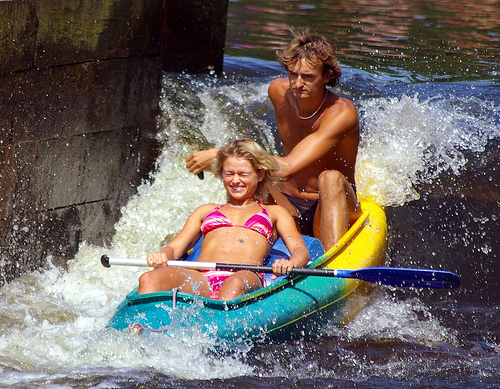

1/1 [==============================] - 0s 42ms/step
two men are sitting in the ocean


In [88]:
from IPython.display import Image
ex_image = Image(filename=file_path)
display(ex_image)
print(greedy_search(pic))

In [90]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 46)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 46, 200)      3947000     ['input_6[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_5[0][0]']                
                                                                                            

In [94]:
with tf.summary.create_file_writer('./graphs').as_default():
    tf.summary.trace_on(graph=True, profiler=True)
    tf.summary.trace_export(name="model_trace", step=0, profiler_outdir='./graphs')

Instructions for updating:
use `tf.profiler.experimental.start` instead.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.
